In [54]:
!pip install librosa pandas tensorflow scikit-learn kaggle


In [55]:
import os
import pandas as pd
import numpy as np
import librosa
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [56]:
def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)

        # Concatenate all features
        features = np.concatenate([
            mfcc.mean(axis=1),
            chroma.mean(axis=1),
            spectral_contrast.mean(axis=1),
        ])

        return features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return np.zeros(13 + 12 + 7)  # Adjusted for the number of features


In [57]:
# Paths to the CSV files
train_csv_path = os.path.join('models', 'archive', 'cv-valid-train.csv')
test_csv_path = os.path.join('models', 'archive', 'cv-valid-test.csv')

# Load the CSV files
train_df = pd.read_csv(train_csv_path).head(1000)
test_df = pd.read_csv(test_csv_path).head(1000)

In [58]:
train_audio_dir = os.path.join('models', 'archive', 'cv-valid-train')
test_audio_dir = os.path.join('models', 'archive', 'cv-valid-test')

In [59]:
# Extract features for all training audio files
train_audio_files = train_df['filename'].apply(lambda x: os.path.join(train_audio_dir, x)).tolist()
train_labels = train_df['gender'].tolist()

# Extract features for all test audio files
test_audio_files = test_df['filename'].apply(lambda x: os.path.join(test_audio_dir, x)).tolist()
test_labels = test_df['gender'].tolist()


In [60]:
# Extract features for all training audio files
print('processing the training audio files...')
train_features = [extract_features(file) for file in train_audio_files]
print('Done.')
# Extract features for all test audio files
print('processing the testing audio files')
test_features = [extract_features(file) for file in test_audio_files]


Processing models/archive/cv-valid-train/cv-valid-train/sample-000000.mp3
Processing models/archive/cv-valid-train/cv-valid-train/sample-000001.mp3
Processing models/archive/cv-valid-train/cv-valid-train/sample-000002.mp3
Processing models/archive/cv-valid-train/cv-valid-train/sample-000003.mp3
Processing models/archive/cv-valid-train/cv-valid-train/sample-000004.mp3
Processing models/archive/cv-valid-train/cv-valid-train/sample-000005.mp3
Processing models/archive/cv-valid-train/cv-valid-train/sample-000006.mp3
Processing models/archive/cv-valid-train/cv-valid-train/sample-000007.mp3
Processing models/archive/cv-valid-train/cv-valid-train/sample-000008.mp3
Processing models/archive/cv-valid-train/cv-valid-train/sample-000009.mp3


KeyboardInterrupt: 

In [45]:

# Convert labels to numerical format
encoder = LabelEncoder()
encoded_train_labels = encoder.fit_transform(train_labels)
encoded_test_labels = encoder.transform(test_labels)  # Transform using the same encoder


In [46]:
# Convert to numpy arrays for TensorFlow compatibility
X_train = np.array(train_features)
X_test = np.array(test_features)
y_train = np.array(encoded_train_labels)
y_test = np.array(encoded_test_labels)


In [47]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(np.unique(encoded_train_labels)), activation='softmax')
])


/home/fareed-sayed/Documents/mp3-tone-model /venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [48]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [49]:
!pip install seaborn matplotlib

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


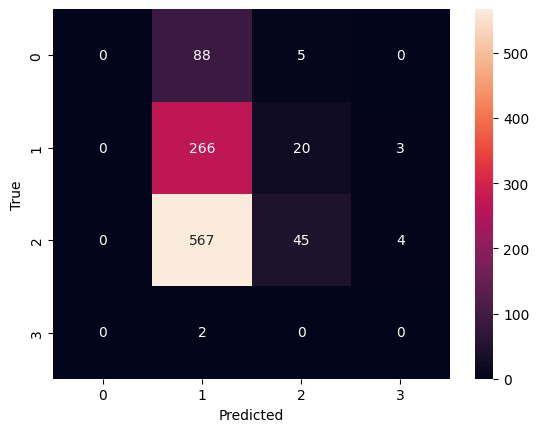

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_test and predictions are available
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

cm = confusion_matrix(y_test, predicted_classes)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [51]:
# Train the model
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4135 - loss: 31.2207 - val_accuracy: 0.6160 - val_loss: 3.1807
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4809 - loss: 10.6608 - val_accuracy: 0.6160 - val_loss: 1.3687
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4530 - loss: 7.5077 - val_accuracy: 0.6120 - val_loss: 1.1575
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4616 - loss: 4.4836 - val_accuracy: 0.6160 - val_loss: 1.0181
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4870 - loss: 3.2654 - val_accuracy: 0.6100 - val_loss: 0.9698
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4657 - loss: 2.8643 - val_accuracy: 0.6160 - val_loss: 1.0386
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4938 - loss: 2.0233 - val_accuracy: 0.6160 - val_loss: 1.0207
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5151 - loss: 1.7043 - val_accuracy: 0.6160 - val_lo

In [52]:
def predict_tone(audio_file):
    features = extract_features(audio_file)
    features = np.expand_dims(features, axis=0)
    prediction = model.predict(features)
    predicted_label = encoder.inverse_transform([np.argmax(prediction)])
    return predicted_label

In [53]:
example_audio = 'sample_audio2.ogg'  # Replace with an actual file path
print(predict_tone(example_audio))

Processing sample_audio.ogg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
['nan']
